In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

In [2]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            Stock1 = data[keys[i]]
            Stock2 = data[keys[j]]
            result = coint(Stock1, Stock2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [4]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2018, 1, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']


df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  11 of 11 completed


,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,
2017-12-22,43.752499,175.000000,10.54,37.759998,21.26,145.793503,28.860001,85.510002,47.360001,64.730003,267.510010
2017-12-26,42.642502,174.440002,10.46,37.939999,21.23,146.108994,28.860001,85.400002,47.430000,64.300003,267.190002
2017-12-27,42.650002,175.360001,10.53,37.610001,21.27,146.395798,28.879999,85.709999,47.380001,64.540001,267.320007
2017-12-28,42.770000,175.550003,10.55,37.919998,21.15,147.265778,28.870001,85.720001,47.520000,64.379997,267.869995
2017-12-29,42.307499,175.240005,10.28,37.740002,21.01,146.673035,28.500000,85.540001,47.279999,64.019997,266.859985


[('AAPL', 'SPY'), ('ADBE', 'MSFT'), ('HPQ', 'ORCL')]


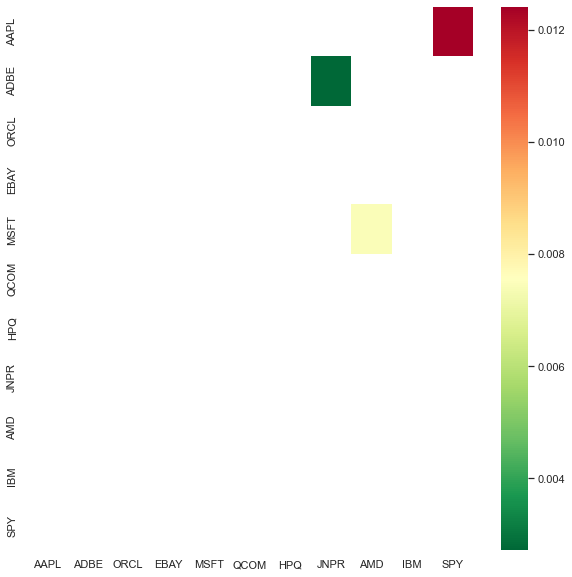

In [5]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [6]:
Stock1 = df['AAPL']
Stock2 = df['SPY']

score, pvalue, _ = coint(Stock1, Stock2)
pvalue

0.012408987621700583

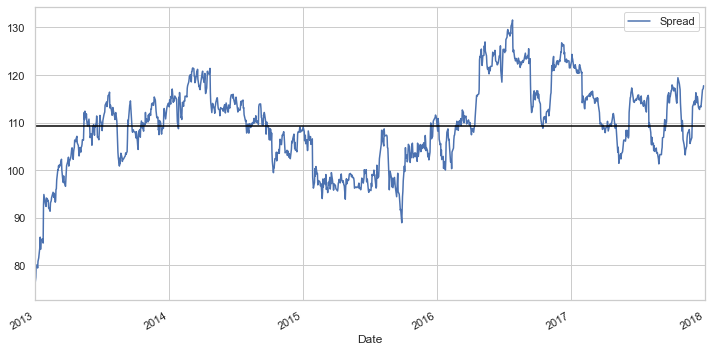

In [7]:
Stock1 = sm.add_constant(Stock1)
results = sm.OLS(Stock2, Stock1).fit()
Stock1 = Stock1['AAPL']
b = results.params['AAPL']

spread = Stock2 - b * Stock1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread'])

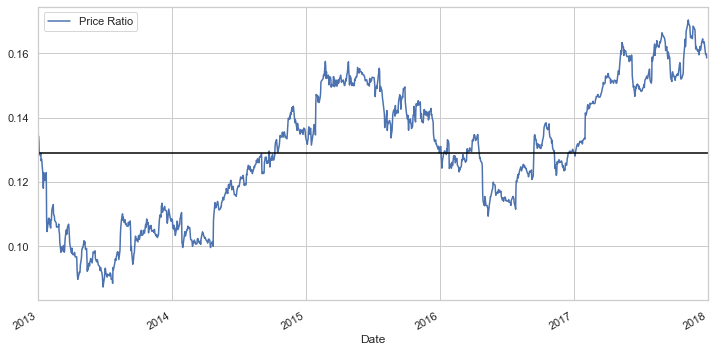

In [8]:
ratio = Stock1/Stock2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio'])

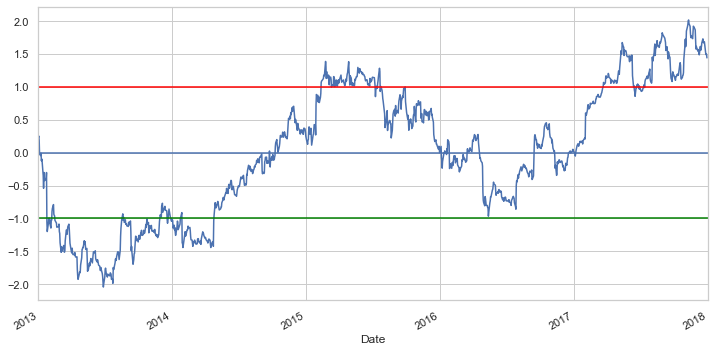

In [9]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2018-01-01')
plt.show()

In [10]:
ratios = df['AAPL'] / df['SPY'] 
print(len(ratios) * .70 ) 

882.0


In [11]:
train = ratios[:881]
test = ratios[881:]

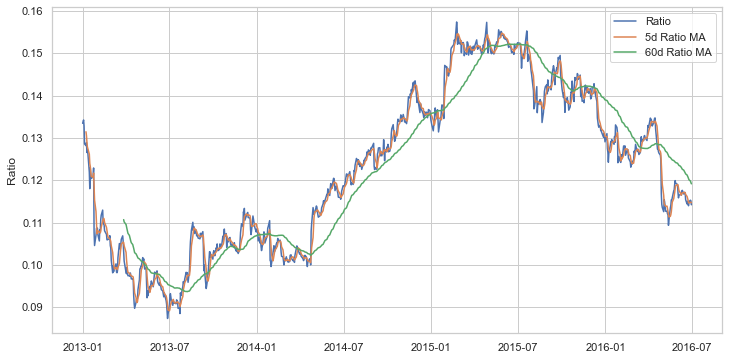

In [12]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

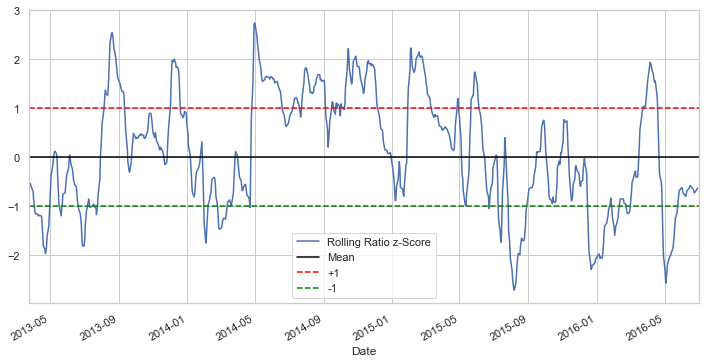

In [13]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2013-03-25', '2016-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

In [14]:
len(zscore_60_5[zscore_60_5.isna()])

59

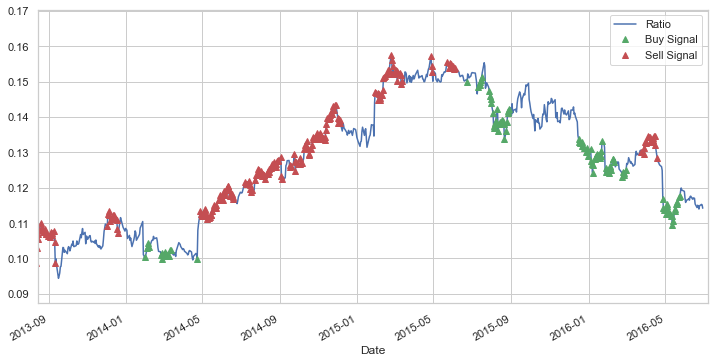

In [15]:
plt.figure(figsize=(12,6))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

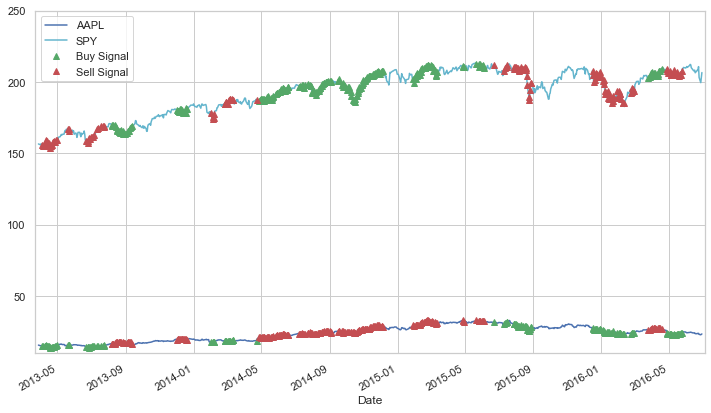

In [16]:
plt.figure(figsize=(12,7))
Stock1 = df['AAPL'].iloc[:881]
Stock2 = df['SPY'].iloc[:881]

Stock1[60:].plot(color='b')
Stock2[60:].plot(color='c')
buyR = 0*Stock1.copy()
sellR = 0*Stock1.copy()

# When you buy the ratio, you buy stock Stock1 and sell Stock2
buyR[buy!=0] = Stock1[buy!=0]
sellR[buy!=0] = Stock2[buy!=0]

# When you sell the ratio, you sell stock Stock1 and buy Stock2
buyR[sell!=0] = Stock2[sell!=0]
sellR[sell!=0] = Stock1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(Stock1.min(), Stock2.min()), max(Stock1.max(), Stock2.max())))
plt.ylim(10, 250)
plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['AAPL', 'SPY', 'Buy Signal', 'Sell Signal'])
plt.show()

In [17]:
def trade(Stock1, Stock2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = Stock1/Stock2
    ma1 = ratios.rolling(window=window1,center=False).mean()
    ma2 = ratios.rolling(window=window2,center=False).mean()
    std = ratios.rolling(window=window2,center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    portfolio = pd.DataFrame()
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += Stock1[i] - Stock2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
#             print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= Stock1[i] - Stock2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
#             print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += Stock1[i] * countS1 + Stock2[i] * countS2
            countS1 = 0
            countS2 = 0
#             print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))       
    
    return money


In [18]:
trade(df['ADBE'].iloc[881:], df['EBAY'].iloc[881:], 60, 5)

1314.449494779637

In [19]:
from pykalman import KalmanFilter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=2)

Text(0, 0.5, 'Value')

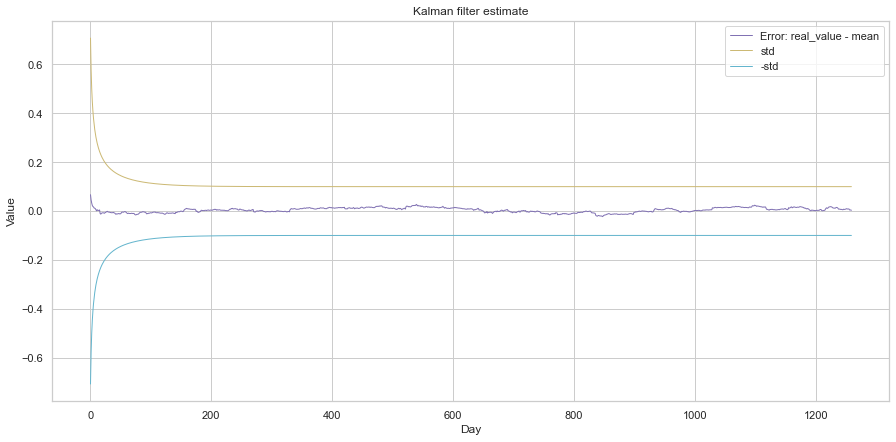

In [20]:
kf = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.0001)

mean, cov = kf.filter(ratio.values)
mean, std = mean.squeeze(), np.std(cov.squeeze())

plt.figure(figsize=(15,7))
plt.plot(ratio.values - mean, 'm', lw=1)
plt.plot(np.sqrt(cov.squeeze()), 'y', lw=1)
plt.plot(-np.sqrt(cov.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')


In [90]:
def kalmantrade(Stock1, Stock2, window1, window2):
    
     # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratio = pd.DataFrame(Stock1/Stock2,columns=['ratio'])
    data = pd.concat([Stock1,Stock2,ratio],axis=1)
    mean, cov =  kf.filter(ratio.values)
    data['mean'] = mean.squeeze()
    data['cov'] = cov.squeeze()
    data['std'] = np.sqrt(data['cov'])
    data = data.dropna()
    
    data['ma'] = data['ratio'].rolling(5).mean()
    data['z_score'] = (data['ma'] - data['mean'])/data['std']

    # Initialise positions as zero
    data['position_1'] = np.nan
    data['position_2'] = np.nan
    # Generate buy, sell and square off signals as: z<-1 buy, z>1 sell and -1<z<1 liquidate the position
    for i in range (data.shape[0]):
        if data['z_score'].iloc[i] < -1:
            data['position_1'].iloc[i] = 1
            data['position_2'].iloc[i] = -round(data['ratio'].iloc[i],0)
        if data['z_score'].iloc[i] > 1:
            data['position_1'].iloc[i] = -1
            data['position_2'].iloc[i] = round(data['ratio'].iloc[i],0)
        if (abs(data['z_score'].iloc[i]) < 1) & (abs(data['z_score'].iloc[i]) > 0):
            data['position_1'].iloc[i] = 0
            data['position_2'].iloc[i] = 0

    # Calculate returns
    data['returns'] = ((Stock1-Stock1.shift(1)/Stock1.shift(1))*data['position_1'].shift(1)
                       + ((Stock2-Stock2.shift(1)/Stock2.shift(1))*data['position_2'].shift(1)))
    money = data['returns'].sum()
    return money,data